In [28]:
import os
import json
import time
import threading

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

In [60]:
sample_video = {
    "positions": {
        "1.0": {
            "Nose": [1, 1, 1],
            "Left_eye": [1, 1, 1],
            # Other joint (total 33 joints)
        },
        "2.0": {
            "Nose": [2, 2, 2],
            "Left_eye": [2, 2, 2],
        },
        "3.0": {
            "Nose": [3, 3, 3],
            "Left_eye": [3, 3, 3],
        },
        "4.0": {
            "Nose": [4, 4, 4],
            "Left_eye": [4, 4, 4],
        },
        # Other frames (depend on the length of the video)
    }
}

sample_video["positions"]["1.0"]["Nose"]

[1, 1, 1]

  <!-- for column in row.index:
            # Extract joint name and position (e.g., Nose_x)
            joint = '_'.join(column.split('_')[1:])
            if joint not in mean_data_series:
                mean_data_series[joint] = []
            mean_data_series[joint].append(row[column]) -->

Let say we have
a[1_a_x:5, 1_a_y:4, 2_a_x:3, 2_a_y:7]
The above code give:
result = {
a_x:[5,3],
a_y:[4,7]
}


In [29]:
def getFilesPath(directory):
    files = []
    for root, dirs, file in os.walk(directory):
        for f in file:
            files.append(os.path.join(root, f))
    return files


def loadFiles(files_path, activities, joints_mapping, target_frames=30):
    """
    Load and process activity data files.

    This function loads JSON files containing activity data, resamples the data to a target number of frames,
    flattens the data, and combines it into a single DataFrame. The function filters files based on the specified
    activities and processes only those files.

    Parameters:
    - files_path (list of str): List of file paths to be processed.
    - activities (list of str): List of activity names to filter the files.
    - joints_mapping (list): Dictionary mapping joint names to their indices.
    - target_frames (int, optional): The target number of frames to resample the data to. Default is 30.

    Returns:
    - pd.DataFrame: A DataFrame containing the processed and combined activity data. If no data is processed, 
    an empty DataFrame is returned.
    """
    activity_dfs = []
    for activity in activities:
        for file_path in files_path:
            if file_path.endswith('.json') and activity in file_path:
                with open(file_path, 'r') as file:
                    file_data = json.load(file)
                    resample_file_data = resample_video(file_data, joints_mapping, target_frames)
                    if resample_file_data is None:
                        continue
                    file_df = flatternData(resample_file_data, joints_mapping)
                    file_df.insert(0, 'Group', file_path.split('\\')[-1].split('-')[0])
                    file_df.insert(1, 'Activity', activity)
                    activity_dfs.append(file_df)

    if activity_dfs:
        final_df = pd.concat(activity_dfs, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()


def flatternData(data, joints_mapping):
    # Create a list of dictionaries for each timestamp and jo   int
    flattened_data = [
        {f'{timestamp}_{joint}_{axis}': position[joint][i]
            for joint in joints_mapping if joint in position
            for i, axis in enumerate(['x', 'y', 'z'])}
        for timestamp, position in data.items()
    ]

    # Flatten the list of dictionaries into a single dictionary
    flattened_data = {k: v for d in flattened_data for k, v in d.items()}
    return pd.DataFrame([flattened_data])


def resample_video(video_data, joint_mapping, target_frames=30):
    # Get the original frame numbers and convert to float
    original_frames = np.array([float(k) for k in video_data['positions'].keys()])
    # check that video has at least 4 frames

    if len(original_frames) < 50:
        return None
    # Create new evenly spaced frames
    new_frames = np.linspace(min(original_frames), max(original_frames), target_frames)

    # Get all unique joints
    joints = list(next(iter(video_data['positions'].values())).keys())

    # Initialize the resampled data structure
    resampled_data = {str(float(i)): {} for i in range(1, target_frames + 1)}

    # Interpolate each joint's coordinates
    for joint in joint_mapping:
        # Extract x, y, z coordinates for the current joint across all frames
        coords = np.array([video_data['positions'][str(frame)][joint] for frame in original_frames])
        x_coords, y_coords, z_coords = coords[:, 0], coords[:, 1], coords[:, 2]

        # Create cubic interpolation functions for each coordinate
        x_interp = interp1d(original_frames, x_coords, kind='cubic')
        y_interp = interp1d(original_frames, y_coords, kind='cubic')
        z_interp = interp1d(original_frames, z_coords, kind='cubic')

        # Apply interpolation to get new coordinates
        for i, frame in enumerate(new_frames, 1):  # Start counting from 1
            resampled_data[str(float(i))][joint] = [
                float(x_interp(frame)),
                float(y_interp(frame)),
                float(z_interp(frame))
            ]
    return resampled_data


def calculateFeatureForAllVideos(df):
    # Store the group and activity columns
    labed_df = df[['Group', 'Activity']]

    # Ignore the group and activity columns for calculation
    df = df.drop(columns=['Group', 'Activity'])

    # Extract joint names and coordinates
    joint_names = df.columns.str.split('_').str[1:].str.join('_')

    # Calculate statistics for each joint
    mean_df = df.T.groupby(joint_names).mean().T
    median_df = df.T.groupby(joint_names).median().T
    std_df = df.T.groupby(joint_names).std().T
    var_df = df.T.groupby(joint_names).var().T
    min_df = df.T.groupby(joint_names).min().T
    max_df = df.T.groupby(joint_names).max().T
    range_df = max_df - min_df

    # Combine all statistics into a single DataFrame
    stats_df = pd.concat([mean_df, median_df, std_df, var_df, min_df, max_df, range_df], axis=1)
    stats_df.columns = [f'{col}_mean' for col in mean_df.columns] + \
                       [f'{col}_median' for col in median_df.columns] + \
                       [f'{col}_std' for col in std_df.columns] + \
                       [f'{col}_var' for col in var_df.columns] + \
                       [f'{col}_min' for col in min_df.columns] + \
                       [f'{col}_max' for col in max_df.columns] + \
                       [f'{col}_range' for col in range_df.columns]

    # Add back the group and activity columns
    stats_df.insert(0, 'Group', labed_df['Group'])
    stats_df.insert(1, 'Activity', labed_df['Activity'])

    return stats_df


def group_by_activity(dfs, onehot_columns):
    # Concatenate all DataFrames in the list
    merged_df = pd.concat(dfs, ignore_index=True)
    # Onehot the onehot_columns
    merged_df = pd.get_dummies(merged_df, columns=onehot_columns)
    # Get unique activities
    # activities = merged_df['Activity'].unique()

    # # Split the merged DataFrame by activity
    # split_dfs = {activity: merged_df[merged_df['Activity'] == activity] for activity in activities}

    return merged_df

In [30]:
# List of joint names
coco_joint_mapping = [
    "Nose",
    "Left_eye",
    "Right_eye",
    "Left_ear",
    "Right_ear",
    "Left_shoulder",
    "Right_shoulder",
    "Left_elbow",
    "Right_elbow",
    "Left_wrist",
    "Right_wrist",
    "Left_hip",
    "Right_hip",
    "Left_knee",
    "Right_knee",
    "Left_ankle",
    "Right_ankle"
]

In [63]:
# path to data
root_path = os.getcwd()
group1A_path = os.path.join(root_path, 'Group1A', 'blazepose')
group2A_path = os.path.join(root_path, 'Group2A', 'blazepose')
group3_path = os.path.join(root_path, 'Group3', 'blazepose')

group1B_path = os.path.join(root_path, 'Group1B', 'blazepose')
group2B_path = os.path.join(root_path, 'Group2B', 'blazepose')

# activities
activities = ['CTK', 'ELK', 'RTK']
# activities = ['ELK']

# Get paths
group1A_files_path = getFilesPath(group1A_path)
group2A_files_path = getFilesPath(group2A_path)
group3_files_path = getFilesPath(group3_path)

group1B_files_path = getFilesPath(group1B_path)
group2B_files_path = getFilesPath(group2B_path)

In [64]:
# Load data
group1A_df = loadFiles(group1A_files_path, activities, openpose_joint_mapping, 200)
group2A_df = loadFiles(group2A_files_path, activities, openpose_joint_mapping, 200)
group3_df = loadFiles(group3_files_path, activities, openpose_joint_mapping, 200)

group1B_df = loadFiles(group1B_files_path, activities, openpose_joint_mapping, 200)
group2B_df = loadFiles(group2B_files_path, activities, openpose_joint_mapping, 200)

# Store data to csv
group1A_df.to_csv('group1A.csv', index=False)
group2A_df.to_csv('group2A.csv', index=False)
group3_df.to_csv('group3.csv', index=False)

group1B_df.to_csv('group1B.csv', index=False)
group2B_df.to_csv('group2B.csv', index=False)

In [31]:
# Load data from csv
group1A_df = pd.read_csv('group1A.csv')
group2A_df = pd.read_csv('group2A.csv')
group3_df = pd.read_csv('group3.csv')
group1B_df = pd.read_csv('group1B.csv')
group2B_df = pd.read_csv('group2B.csv')
group2A_df.head(2)

,Group,Activity,1.0_Nose_x,1.0_Nose_y,1.0_Nose_z,1.0_Left_eye_x,1.0_Left_eye_y,1.0_Left_eye_z,1.0_Right_eye_x,1.0_Right_eye_y,...,200.0_Left_knee_z,200.0_Right_knee_x,200.0_Right_knee_y,200.0_Right_knee_z,200.0_Left_ankle_x,200.0_Left_ankle_y,200.0_Left_ankle_z,200.0_Right_ankle_x,200.0_Right_ankle_y,200.0_Right_ankle_z
0,G2A,CTK,0.539282,0.431655,-0.384252,0.543288,0.422329,-0.375004,0.535076,0.421193,...,-0.014480,0.493701,0.693743,0.007707,0.566503,0.806848,0.067230,0.491475,0.797624,0.094346
1,G2A,CTK,0.536172,0.423099,-0.371713,0.541568,0.413143,-0.360224,0.530744,0.413438,...,-0.044134,0.491112,0.689791,0.004020,0.569369,0.802822,0.067648,0.490229,0.793349,0.112206


In [32]:
# Calculate mean for all videos
group1A_mean_df = calculateFeatureForAllVideos(group1A_df)


group2A_mean_df = calculateFeatureForAllVideos(group2A_df)


group3_mean_df = calculateFeatureForAllVideos(group3_df)

group1B_mean_df = calculateFeatureForAllVideos(group1B_df)
group2B_mean_df = calculateFeatureForAllVideos(group2B_df)


# Add labels


group1A_mean_df.insert(2, 'Backpain', 1)


group2A_mean_df.insert(2, 'Backpain', 0)


group3_mean_df.insert(2, 'Backpain', 0)

group1B_mean_df.insert(2, 'Backpain', 1)
group2B_mean_df.insert(2, 'Backpain', 0)

In [35]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seglearn as sgl
from imblearn.pipeline import Pipeline as ImbPipeline


def perform_grid_search(X, y, param_grid, model, resampler, test_size=0.2, random_state=42, cv=5, n_jobs=6, verbose=3):
    """
    Perform grid search and cross-validation for the given model and parameter grid.

    Parameters:
    - X (pd.DataFrame): The input features.
    - y (pd.Series): The target labels.
    - param_grid (dict): The parameter grid for GridSearchCV.
    - model (sklearn estimator): The model to be used in the pipeline.
    - resampler (imblearn instance): The resampling instance to handle imbalance.
    - test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
    - random_state (int, optional): The random seed for splitting the data. Default is 42.
    - cv (int, optional): The number of cross-validation folds. Default is 5.
    - n_jobs (int, optional): The number of jobs to run in parallel. Default is -1 (use all processors).
    - verbose (int, optional): The verbosity level. Default is 3.

    Returns:
    - grid_search (GridSearchCV): The GridSearchCV object after fitting.
    - best_params (dict): The best parameters found by GridSearchCV.
    - best_estimator (Pipeline): The best estimator found by GridSearchCV.
    - accuracy (float): The accuracy of the model on the test set.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    # Define the pipeline with the resampler
    clf = ImbPipeline([
        ("resampler", resampler),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=clf, param_grid=param_grid, cv=cv, n_jobs=n_jobs, verbose=verbose)

    # Perform grid search and cross-validation
    grid_search.fit(X_train, y_train)

    # Get the best estimator
    best_estimator = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_estimator.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return grid_search

In [39]:
train_dataset = group_by_activity(
    [group1B_mean_df, group2B_mean_df, group3_mean_df],
    ['Activity'])

# show the numer of sample for backpain and no backpain with description
print(train_dataset['Backpain'].value_counts())

Backpain
1    1579
0     683
Name: count, dtype: int64


In [51]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

# Prepare the data
X = train_dataset.drop(columns=['Group', 'Backpain'])  # Features
y = train_dataset['Backpain']  # Labels

# Perfom grid search for knn
param_grid_knn = {
    'model__n_neighbors': [3, 4, 5, 6],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search_knn = perform_grid_search(X, y, param_grid_knn, KNeighborsClassifier(), SVMSMOTE())

# Performe grid search for random forest
# param_grid_rf = {
#     'model__n_estimators': [100, 200, 300],
#     'model__max_depth': [10, 20, 30, 40, 50],
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4]
# }
# grid_search_rf = perform_grid_search(X, y, param_grid_rf, RandomForestClassifier())

# print the results for knn and random forest
print("KNN best parameters:", grid_search_knn.best_params_)
print("KNN best score:", grid_search_knn.best_score_)
# print("Random Forest best parameters:", grid_search_rf.best_params_)
# print("Random Forest best score:", grid_search_rf.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
KNN best parameters: {'model__algorithm': 'brute', 'model__n_neighbors': 4, 'model__weights': 'distance'}
KNN best score: 0.9635098942471035


Classification Report:
accuracy: 0.891156462585034
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        50
           1       0.95      0.91      0.93       244

    accuracy                           0.89       294
   macro avg       0.80      0.85      0.82       294
weighted avg       0.90      0.89      0.89       294



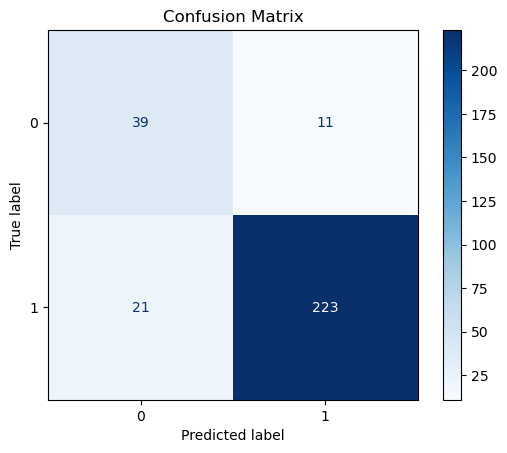

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


to_predict_dataset = group_by_activity([group1A_mean_df, group2A_mean_df], ['Activity'])
X_to_predict = to_predict_dataset.drop(columns=['Group', 'Backpain'])
y_true = to_predict_dataset['Backpain']
y_pred = grid_search_knn.predict(X_to_predict)
accuracy_pred = accuracy_score(y_true, y_pred)

# Print classification report
print("Classification Report:")
print("accuracy:", accuracy_pred)
print(classification_report(y_true, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [50]:


import test


a1 = flatternData(sample_video['positions'], openpose_joint_mapping)
a1.insert(0, 'Group', "gr1a")
a1.insert(1, 'Activity', "CTK")
a2 = flatternData(sample_video['positions'], openpose_joint_mapping)
a2.insert(0, 'Group', "gr1a")
a2.insert(1, 'Activity', "RTK")

testdf = pd.concat([a1, a2], ignore_index=True)
df_encoded = pd.get_dummies(testdf, columns=['Activity'])
df_encoded

NameError: name 'sample_video' is not defined